# Word Count Change Analysis Based on Error Count

This notebook analyzes how the word count of model outputs changes compared to the original sentence as the error count increases.

We use the JSON files generated by the model inference process, measuring:
- The **percentage change** in word count between the original output and the corrupted output.
- The **relationship between model size** and the extent of change in output length.

The analysis includes:
- A line plot of average word count change versus error count.
- A scatter plot showing the correlation between model size and word count change.


In [76]:
# Environment Setup
import os
import matplotlib as mpl
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# Plotting style
sns.set_context("talk", font_scale=1.5)   # Font size globally
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelsize'] = 20        # Axis label font size
plt.rcParams['axes.titlesize'] = 26        # Title font size
plt.rcParams['xtick.labelsize'] = 18       # X tick labels
plt.rcParams['ytick.labelsize'] = 18       # Y tick labels
plt.rcParams['legend.fontsize'] = 16       # Legend font size


## Load Model Output JSON Files

We read the output JSON files for each model and error count. Each JSON contains original and corrupted outputs for a set of questions.


In [77]:
# Define paths
root_path = "../Model_Inference/model_outputs"

# Load all models
model_dirs = [d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]

# Extract model size info from one JSON file per model
model_sizes = {}
for model_dir in model_dirs:
    model_path = os.path.join(root_path, model_dir)
    sample_jsons = [f for f in os.listdir(model_path) if f.endswith(".json")]
    if sample_jsons:
        with open(os.path.join(model_path, sample_jsons[0]), "r", encoding="utf-8") as f:
            data = json.load(f)
            model_sizes[model_dir] = data.get("model_size", -1)

# Prepare dataframe for analysis
records = []

for model_dir in model_dirs:
    model_path = os.path.join(root_path, model_dir)
    json_files = [f for f in os.listdir(model_path) if f.endswith(".json")]

    for json_file in json_files:
        error_count = int(json_file.replace(".json", ""))
        with open(os.path.join(model_path, json_file), "r", encoding="utf-8") as f:
            data = json.load(f)

        for qid, outputs in data.items():
            if qid == "model_size":
                continue
            try:
                orig_output = outputs[0]["output"]
                orig_word_count = len(orig_output.split())

                variant_word_counts = [len(variant["output"].split()) for variant in outputs[1:]]
                if len(variant_word_counts) == 0 or orig_word_count == 0:
                    continue

                avg_variant_word_count = np.mean(variant_word_counts)

                percent_change = ((avg_variant_word_count - orig_word_count) / orig_word_count) * 100

                records.append({
                    "model": model_dir,
                    "error_count": error_count,
                    "percent_change": percent_change,
                    "model_size": model_sizes.get(model_dir, -1)
                })
            except Exception:
                continue

df = pd.DataFrame(records)

# Aggregate: Mean percentage change per model and error count
summary_df = df.groupby(["model", "error_count", "model_size"], as_index=False)["percent_change"].mean()


## Define Model Colors

We use the same color mapping (coolwarm colormap) as in the previous analysis. Models are ordered by their size.


In [78]:
# Prepare color mapping
model_info = summary_df.groupby("model")["model_size"].first().sort_values()
model_order = model_info.index.tolist()

norm = mpl.colors.Normalize(vmin=model_info.min(), vmax=model_info.max())
cmap = mpl.cm.coolwarm
colors = [cmap(norm(size)) for size in model_info.values]
palette = dict(zip(model_order, colors))


## Word Count Change vs. Error Count

We plot the average percentage change in word count against the number of introduced errors for each model.


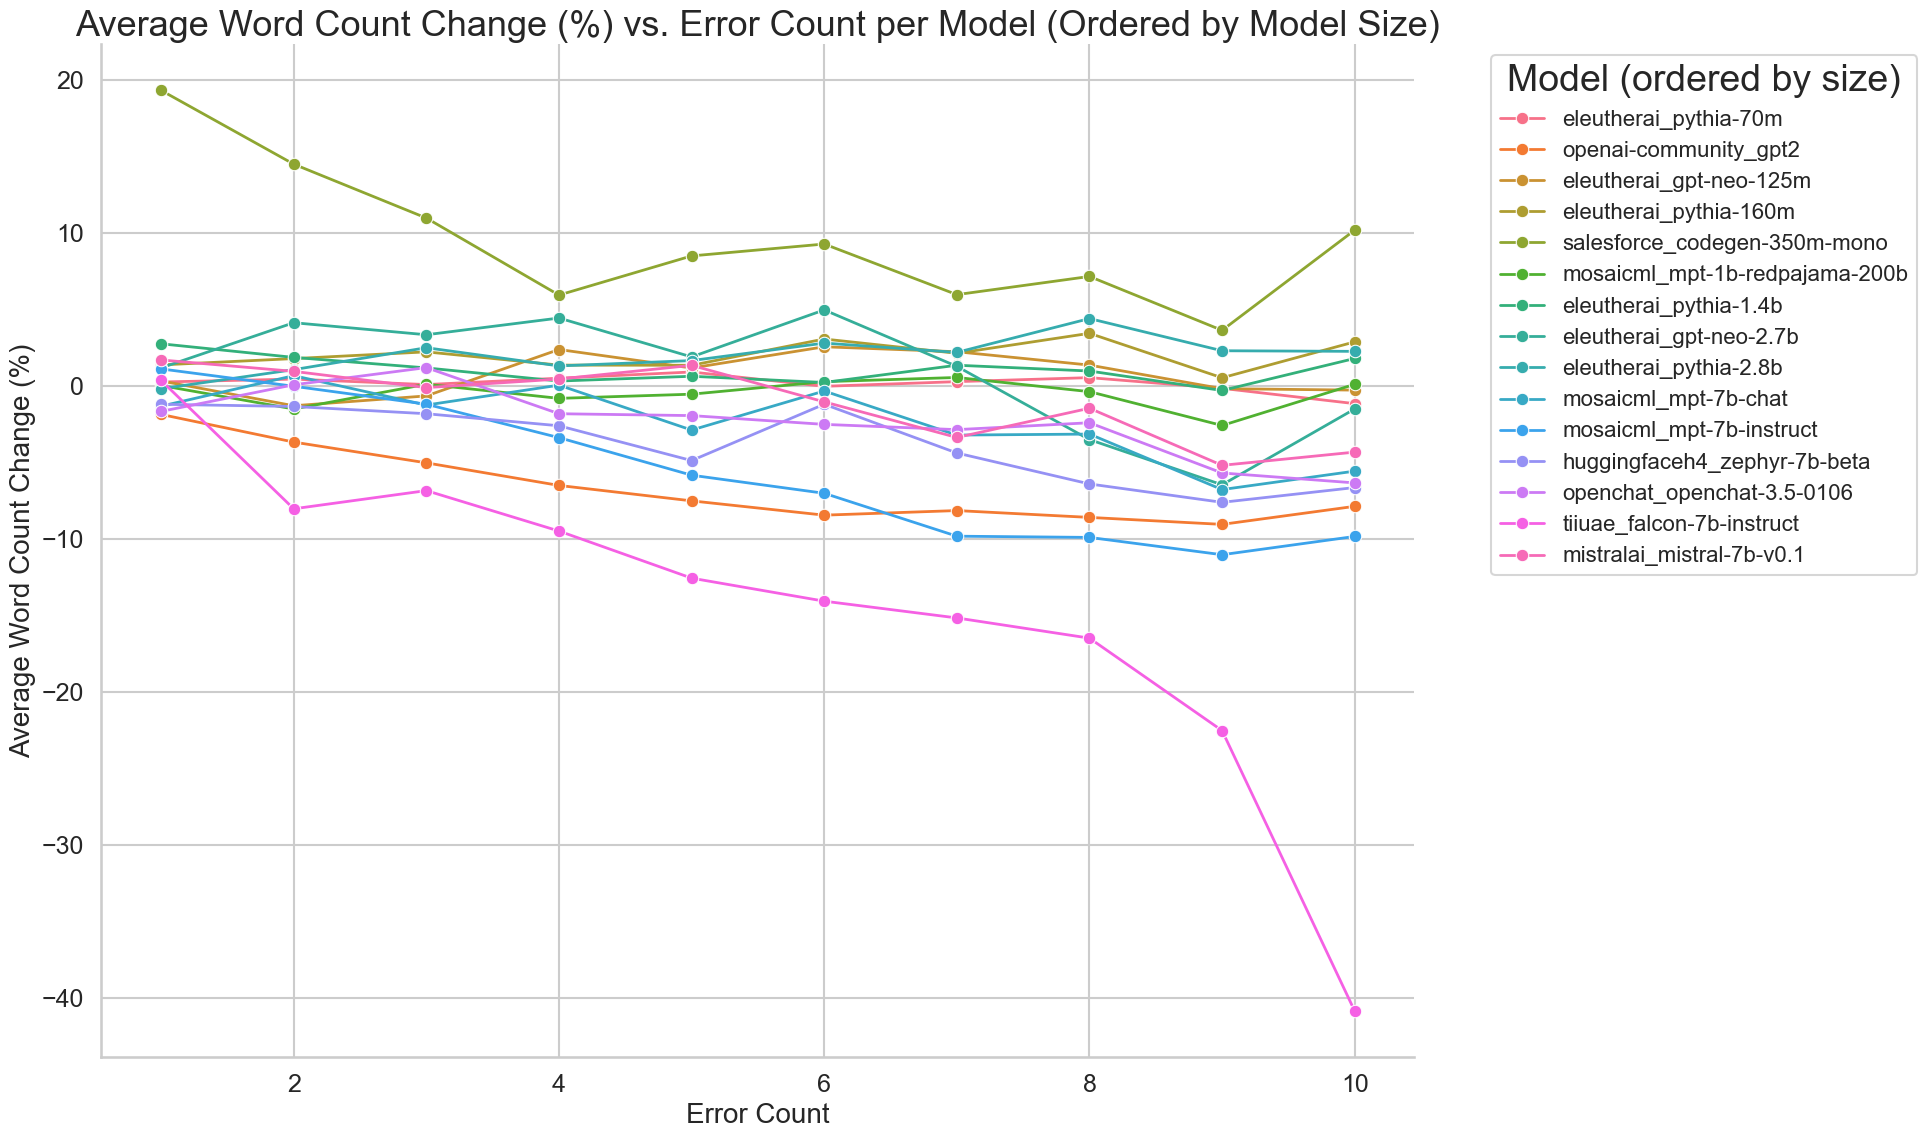

In [79]:
# Prepare model order by model size
model_order = (summary_df.groupby(["model", "model_size"])
               .size()
               .reset_index()
               .sort_values("model_size")["model"]
               .tolist())

# Lineplot: Average Word Count Change per Model (Ordered by Model Size)
plt.figure(figsize=(20, 12))
sns.lineplot(
    data=summary_df,
    x="error_count",
    y="percent_change",
    hue="model",
    hue_order=model_order,        # <-- Order models by size
    marker="o",
    linewidth=2
)
plt.title("Average Word Count Change (%) vs. Error Count per Model (Ordered by Model Size)")
plt.xlabel("Error Count")
plt.ylabel("Average Word Count Change (%)")
plt.legend(
    title="Model (ordered by size)",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    ncol=1,
    frameon=True
)
plt.tight_layout()
plt.show()


## Model Size vs. Word Count Change at Maximum Error Count

We analyze the relationship between model size and the extent of word count change at the highest error count.


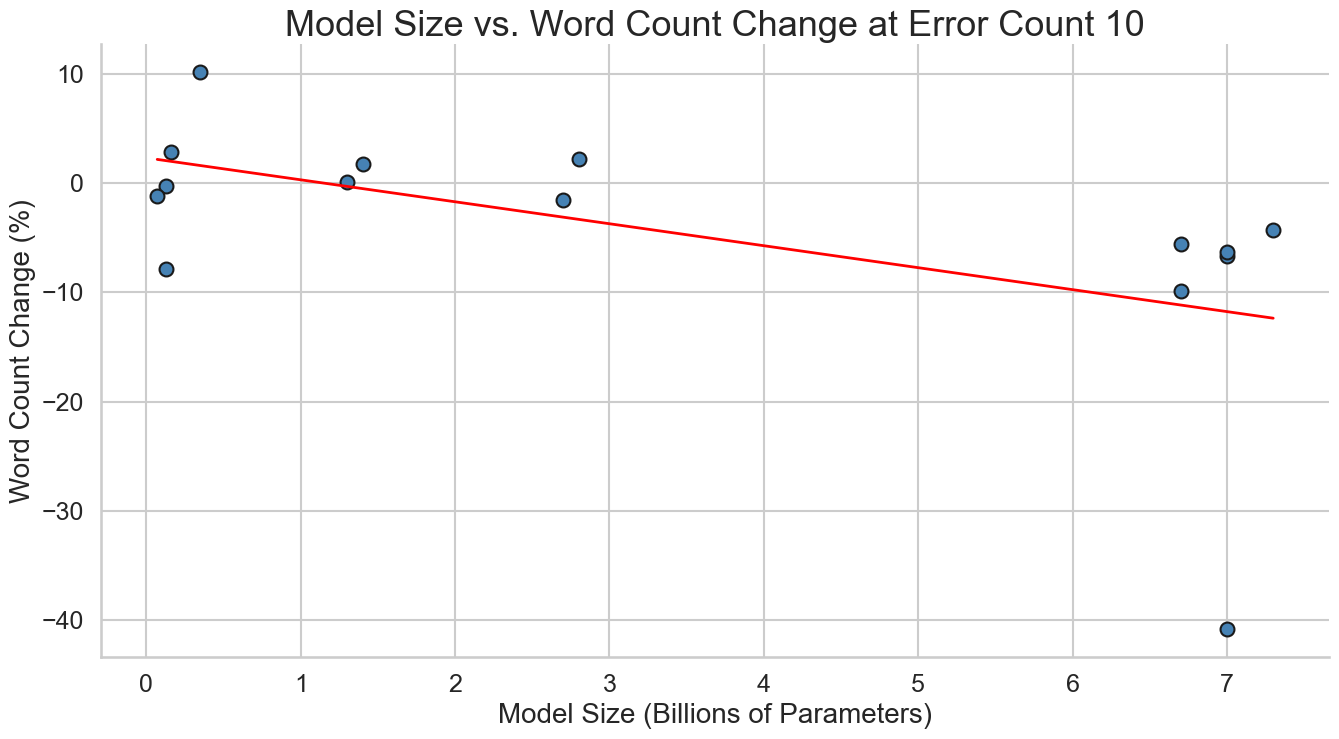

In [80]:
# Select Data at highest error count
max_error_count = summary_df["error_count"].max()
last_step_df = summary_df[summary_df["error_count"] == max_error_count]

plt.figure(figsize=(14, 8))

# Scatter plot — all points the same color
plt.scatter(
    last_step_df["model_size"] / 1e9,
    last_step_df["percent_change"],
    color="steelblue",
    s=100,
    edgecolors="k"
)

# Add regression line — without confidence interval
sns.regplot(
    x=last_step_df["model_size"] / 1e9,
    y=last_step_df["percent_change"],
    scatter=False,            # Do not add points again
    color="red",
    line_kws={"linewidth": 2},
    ci=None                    # No confidence interval area
)

plt.title(f"Model Size vs. Word Count Change at Error Count {max_error_count}")
plt.xlabel("Model Size (Billions of Parameters)")
plt.ylabel("Word Count Change (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Correlation Between Model Size and Word Count Change

We compute the Pearson correlation coefficient to assess the relationship between model size and word count change.


In [81]:
# Pearson Correlation
corr, p_value = pearsonr(last_step_df["model_size"], last_step_df["percent_change"])

print(f"Pearson Correlation between Model Size and Word Count Change: {corr:.3f} (p = {p_value:.3e})")


Pearson Correlation between Model Size and Word Count Change: -0.559 (p = 3.046e-02)


## Scatter Plot with Regression Line After Outlier Removal

We plot the relationship between model size and word count change after removing outliers, including a regression line.


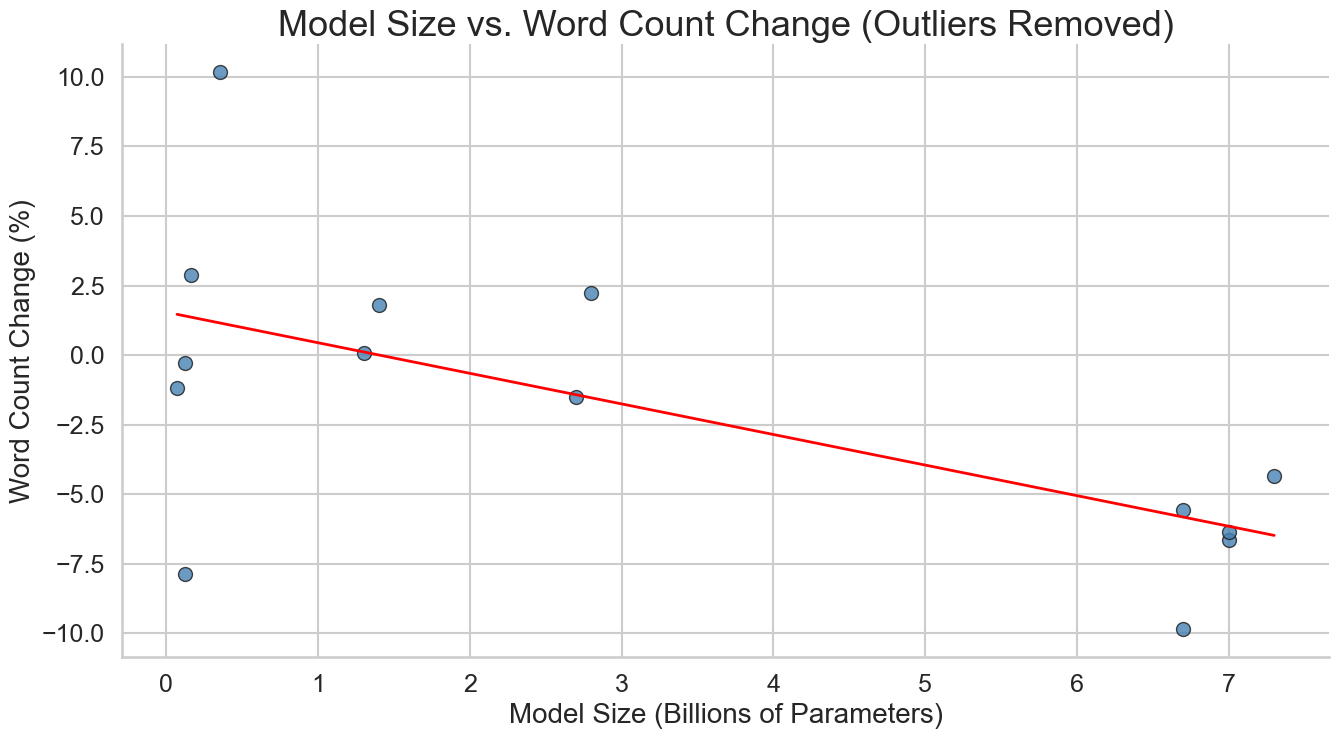

In [82]:
plt.figure(figsize=(14, 8))
sns.regplot(
    x=filtered_df["model_size"] / 1e9,
    y=filtered_df["percent_change"],
    scatter_kws={"s": 100, "edgecolors": "k", "color": "steelblue"},
    line_kws={"color": "red", "linewidth": 2},
    ci=None   # <-- Remove confidence interval
)

plt.title("Model Size vs. Word Count Change (Outliers Removed)")
plt.xlabel("Model Size (Billions of Parameters)")
plt.ylabel("Word Count Change (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Correlation After Removing Outliers

To better understand the relationship between model size and word count change, we remove clear outliers and recompute the correlation. We define outliers as models whose word count change lies beyond 1.5 times the interquartile range (IQR).


In [83]:
# Remove outliers based on IQR
Q1 = last_step_df["percent_change"].quantile(0.25)
Q3 = last_step_df["percent_change"].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter
filtered_df = last_step_df[(last_step_df["percent_change"] >= lower_bound) & (last_step_df["percent_change"] <= upper_bound)]

# Pearson Correlation after outlier removal
filtered_corr, filtered_p_value = pearsonr(filtered_df["model_size"], filtered_df["percent_change"])

print(f"Pearson Correlation after Removing Outliers: {filtered_corr:.3f} (p = {filtered_p_value:.3e})")


Pearson Correlation after Removing Outliers: -0.637 (p = 1.425e-02)
